In [1]:
import re
from datetime import date
import datetime
import pickle
import seaborn as sns

import requests
import pandas as pd
from datetime import datetime
import time, math
import matplotlib.pyplot as plt

# Getting data:
with open('objs.pkl', 'rb') as f:  # Python 3: open(..., 'rb')
     data_combined_with_delta = pickle.load(f)

In [2]:
#import toolboxes
from reddit_toolbox import piecewise_lin_fit, search_mentions

,title,selftext,body,contains
0,https://3mmc.sfsdf.sfdsf.sdfsf,NaN,NaN,False
1,3mmc,NaN,NaN,True
2,3 mmc,NaN,NaN,True
3,3MmC,NaN,NaN,True
4,,3mmc,NaN,True
5,,NaN,3mmc,True
6,,NaN,4 abc,True


In [3]:
def function_find_pattern(string_to_search, dict_of_kwrds):
    r = re.compile(string_to_search)
    newlist = list(filter(lambda elem: r.search(elem[1]), dict_of_kwrds.items()))
    if len(newlist) == 0:
        return string_to_search
    else:
        return dict_of_kwrds[newlist[0][0]]


In [4]:
drug_kwrds = {'4-FA' : '4-FA|4FMP', 
              '4-MMC': '4-MMC|mephedrone | mefedron',
              '6-ABP': '6-APB| Benzofury| Benzo Fury',
              'A-PHP'  : 'alpha-PHP|α-PHP|a-php',
              'Phenibut': 'Phenibut|fenibut'

             }

assert function_find_pattern('mefe', drug_kwrds)=='4-MMC|mephedrone | mefedron', 'didn''t find correct search words'
assert function_find_pattern('ZZZZ', drug_kwrds)=='ZZZZ', 'didn''t find correct search words'

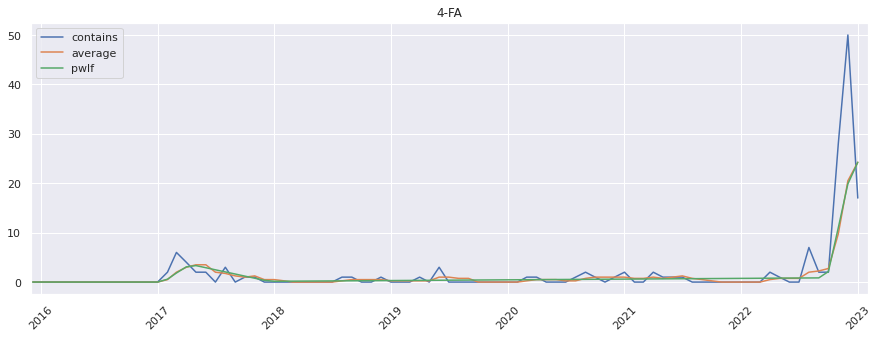

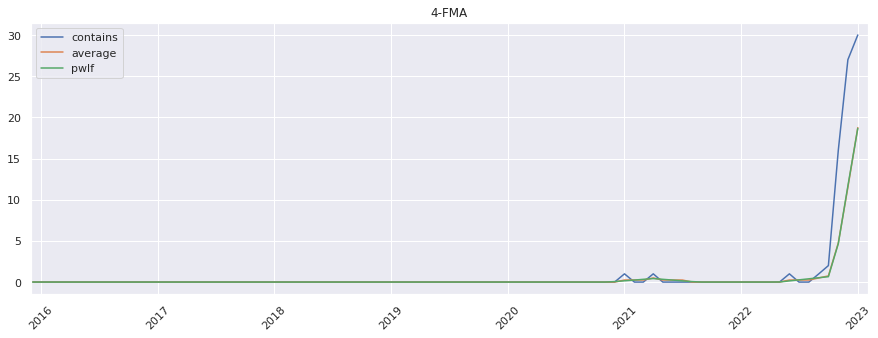

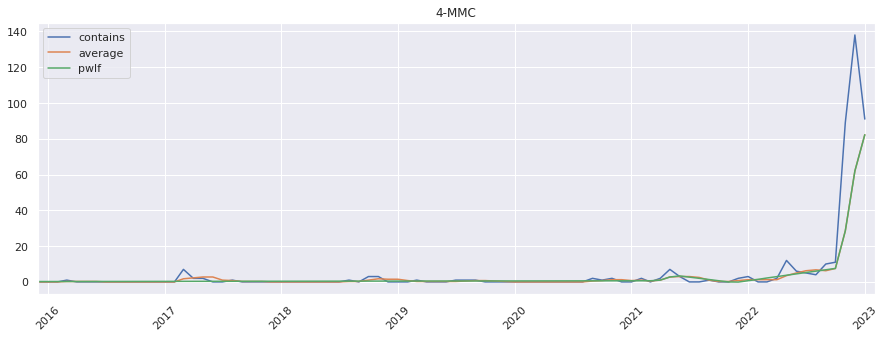

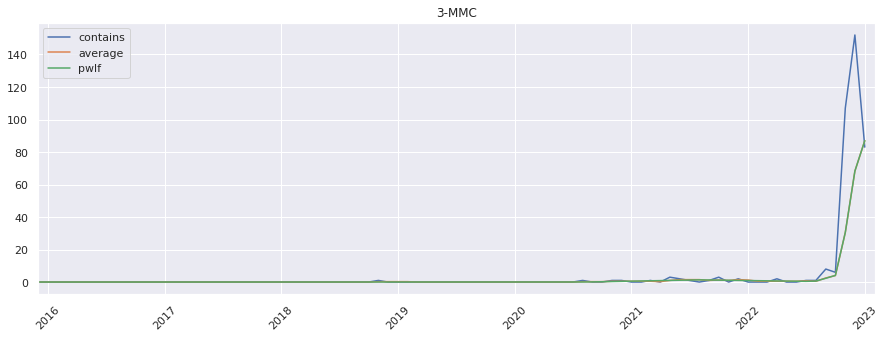

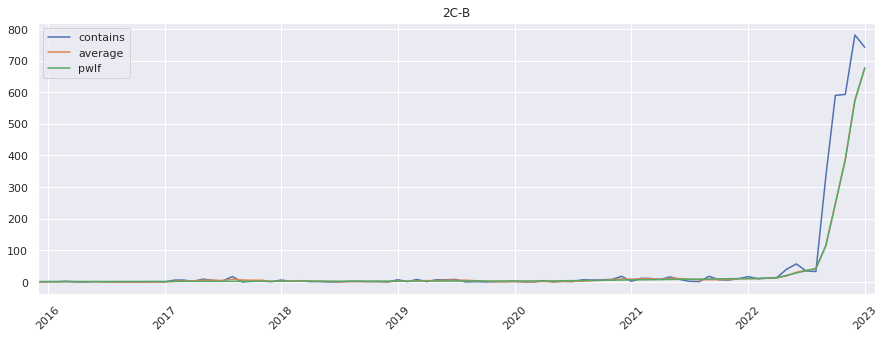

In [5]:
search_drugs = ['4-FA', '4-FMA', '4-MMC', '3-MMC', '2C-B']

drug_mentions = pd.DataFrame()
sns.set()

for i, drug in enumerate(search_drugs):
    search_mentions(data_combined_with_delta, drug_name=function_find_pattern(drug, drug_kwrds) )
    drug_mentions = data_combined_with_delta.groupby('year_month').sum()
    output  = piecewise_lin_fit(drug_mentions, 'contains', 6)

    
    plt.figure(figsize=(15,5))
    plt.plot(drug_mentions.index, drug_mentions['contains'], label='contains')
    plt.plot(output['year_month'], output['average'], label='average')
    plt.plot(output['year_month'], output['pwlf'], label='pwlf')
    plt.xticks(rotation=45)
    plt.xlim(date(2015, 12, 1), date(2023, 2, 1))
    plt.legend()
    plt.title(drug)


In [6]:
data_combined_with_delta

subreddit_name_prefixed        name                author  \
subreddit   id                                                                  
1P_LSD      j4v6oth                r/1P_LSD  t1_j4v6oth   Top_Transition_1095   
            j4tur7l                r/1P_LSD  t1_j4tur7l          oscarcubby10   
            j4syrw2                r/1P_LSD  t1_j4syrw2            Sarthak535   
            j4st1m5                r/1P_LSD  t1_j4st1m5      Nitrous_Acidhead   
            j4srfsv                r/1P_LSD  t1_j4srfsv    Bruhtatochips23415   
...                                     ...         ...                   ...   
tripreports ortmte            r/tripreports   t3_ortmte    COVID19_In_My_ANUS   
            h6k8rlp           r/tripreports  t1_h6k8rlp         AutoModerator   
            h6j360b           r/tripreports  t1_h6j360b         AmtheOutsider   
            orkq7v            r/tripreports   t3_orkq7v  Zealousideal_Pipe_21   
            h6inf96           r/tripreports  t1_h6inf96         AutoModerator   

                                                                 title  \
subreddit   id                                                           
1P_LSD      j4v6oth                                                NaN   
            j4tur7l                                                NaN   
            j4syrw2                                                NaN   
            j4st1m5                                                NaN   
            j4srfsv                                                NaN   
...                                                                ...   
tripreports ortmte   2gs Golden Teachers and 72mg 5-MAPB + hordenin...   
            h6k8rlp                                                NaN   
            h6j360b                                                NaN   
            orkq7v   5 grams Liberty Caps…Healing, Vibration and En...   
            h6inf96                                                NaN   

                                                              selftext  \
subreddit   id                                                           
1P_LSD      j4v6oth                                                NaN   
            j4tur7l                                                NaN   
            j4syrw2                                                NaN   
            j4st1m5                                                NaN   
            j4srfsv                                                NaN   
...                                                                ...   
tripreports ortmte   I have never written a published a trip report...   
            h6k8rlp                                                NaN   
            h6j360b                                                NaN   
            orkq7v   \nWhat’s happening? Hope everyone is enjoying ...   
            h6inf96                                                NaN   

                    num_comments upvote_ratio ups downs view_count score  \
subreddit   id                                                             
1P_LSD      j4v6oth          NaN          NaN   1     0        NaN     1   
            j4tur7l          NaN          NaN   3     0        NaN     3   
            j4syrw2          NaN          NaN   1     0        NaN     1   
            j4st1m5          NaN          NaN   3     0        NaN     3   
            j4srfsv          NaN          NaN   1     0        NaN     1   
...                          ...          ...  ..   ...        ...   ...   
tripreports ortmte             7          1.0  10     0       None    10   
            h6k8rlp          NaN          NaN   1     0        NaN     1   
            h6j360b          NaN          NaN   4     0        NaN     4   
            orkq7v             4          1.0  16     0       None    16   
            h6inf96          NaN          NaN   1     0        NaN     1   

                    link_flair_css_class           